# Eats Cash Arrears Prediction v2
### Author : Vinay Adithya






In [1]:
# numpy and pandas for data manipulation
import numpy as np
import pandas as pd 

# sklearn preprocessing for dealing with categorical variables
from sklearn.preprocessing import LabelEncoder

# File system manangement
import os

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')
#import pandas as pd
#import random
#from sklearn.model_selection import train_test_split

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns

#to shuffle the data
from sklearn.utils import shuffle

#import lightgbm as lgb

from scipy.stats import mode

import datetime
from datetime import timedelta

#### Pulling the data directly from querybuilder using query runner for DSW. Currently commented out the above cell since the query takes a lot of time to run. The data sets have been saved in the current directory 

In [2]:
# getting data using Queryrunner
from queryrunner_client import Client
qr = Client(user_email='vinay.adithya@uber.com')

In [3]:
'''

# Query 
query_string = """
with trips as (
SELECT *,
  case when dns_type IN ('Risk Managed DNS', 'Cash Cancelled DNS') THEN 'Arrear' else 'Not Arrear' END as ArrearStatus
FROM fraud.pmt_risk_cohort_fact a
  join (select *
        from dwh.fact_eats_trip
        where date(datestr) BETWEEN date('{{start_date}}') and date('{{end_date}}')
     
        ) fet on a.trip_uuid = fet.order_trip_uuid
where Lower(country_name) like '%india%'
  AND marketplace IN ('agora', 'eats', 'Eats', 'quasi_eats')
  and from_iso8601_date(a.datestr) BETWEEN date('{{start_date}}') and date('{{end_date}}')
order by 1 ASC ),
  
orders as (select distinct t.*, a.city_name,a.restaurant_uuid,a.order_trip_uuid,a.eater_trip_rank,a.client_uuid,a.card_type,a.eater_request_timestamp_local,
                                a.token_type,eater_uuid,signup_role,is_polymorphed,is_rider,a.country_id,mobile_country_id,has_confirmed_mobile,
                                banned,a.language_code,eats_rating,signup_timestamp,signup_city_id,signup_form,signup_app_version,
                                eater_promotion_code,is_referral,first_eats_login_timestamp,first_eats_activity_timestamp,primary_city_id,
                                a.is_settled
            from trips t 
            join (select dc.city_name as city_name,restaurant_uuid,order_trip_uuid,eater_trip_rank,client_uuid,card_type,eater_request_timestamp_local,
                                token_type,eater_uuid,signup_role,is_polymorphed,is_rider,dc.country_id,mobile_country_id,has_confirmed_mobile,
                                banned,de.language_code,eats_rating,signup_timestamp,signup_city_id,signup_form,signup_app_version,
                                eater_promotion_code,is_referral,first_eats_login_timestamp,first_eats_activity_timestamp,primary_city_id,
                                CASE WHEN ftb.is_settled IS NULL THEN FALSE ELSE ftb.is_settled END AS is_settled
    
                    FROM dwh.fact_eats_trip AS fet
                      INNER JOIN dwh.dim_eater AS de ON fet.client_uuid = de.eater_uuid
                      INNER JOIN dwh.dim_city AS dc ON fet.city_id = dc.city_id
                      LEFT JOIN raw_etl_data.payment_profile AS pp ON pp.random_uuid = fet.eater_payment_profile_uuid
                      LEFT JOIN (SELECT trip_uuid, -1 * amount_local AS amount_local,-1 * amount_usd AS amount_usd,
                                            MAX(CASE WHEN state = 'SETTLED' THEN TRUE ELSE FALSE END) AS is_settled
                                 FROM dwh.fact_trip_bill AS fact_trip_bill
                                 WHERE bill_type = 'SALE'
                                 
                                 AND CAST(datestr AS TIMESTAMP) BETWEEN TIMESTAMP '{{start_date}}' AND TIMESTAMP '{{end_date}}'  
                                 GROUP BY 1,2,3) ftb ON ftb.trip_uuid = fet.order_trip_uuid
                    where date(fet.datestr) BETWEEN date('{{start_date}}') and date('{{end_date}}')
                          ) a on a.order_trip_uuid = t.order_trip_uuid
                          )
  
select distinct *
from orders
where ArrearStatus = 'Not Arrear'

limit 20000
"""
#data = pd.DataFrame(qr.execute('presto', query_string).fetchall())
#app_train,app_test = train_test_split(data,test_size = 0.2)
'''

'\n\n# Query \nquery_string = """\nwith trips as (\nSELECT *,\n  case when dns_type IN (\'Risk Managed DNS\', \'Cash Cancelled DNS\') THEN \'Arrear\' else \'Not Arrear\' END as ArrearStatus\nFROM fraud.pmt_risk_cohort_fact a\n  join (select *\n        from dwh.fact_eats_trip\n        where date(datestr) BETWEEN date(\'{{start_date}}\') and date(\'{{end_date}}\')\n     \n        ) fet on a.trip_uuid = fet.order_trip_uuid\nwhere Lower(country_name) like \'%india%\'\n  AND marketplace IN (\'agora\', \'eats\', \'Eats\', \'quasi_eats\')\n  and from_iso8601_date(a.datestr) BETWEEN date(\'{{start_date}}\') and date(\'{{end_date}}\')\norder by 1 ASC ),\n  \norders as (select distinct t.*, a.city_name,a.restaurant_uuid,a.order_trip_uuid,a.eater_trip_rank,a.client_uuid,a.card_type,a.eater_request_timestamp_local,\n                                a.token_type,eater_uuid,signup_role,is_polymorphed,is_rider,a.country_id,mobile_country_id,has_confirmed_mobile,\n                                banned

## Reading the data

In [4]:
#Creating a balance data set using the 20k positve and negative fraud orders
d1 = pd.read_csv('arrear_mod_20k.csv')
d2 = pd.read_csv('not_arrear_mod_20k.csv')
d3 = pd.concat([d1,d2])
d3.to_csv('balanced_mod_40k.csv',index = False)

In [5]:
data = pd.read_csv('balanced_mod_40k.csv')
data = data.drop(columns = ['Unnamed: 0','Unnamed: 0.1'])
data = shuffle(data)
data['ArrearStatus'] = data.ArrearStatus.map({'Not Arrear': 0,'Arrear': 1})

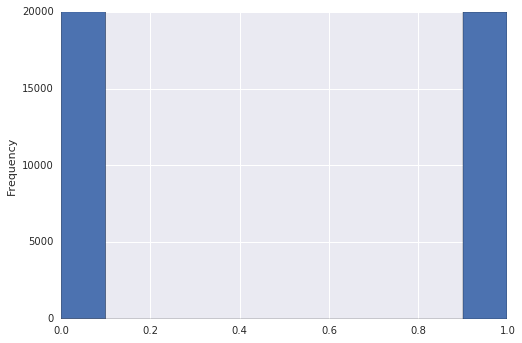

In [6]:
data['ArrearStatus'].value_counts()
data['ArrearStatus'].astype(int).plot.hist()
plt.show()

## Data cleaning

In [7]:
#replacing missing values

data = pd.DataFrame(data)
data.replace(r"\N",np.nan,inplace = True)
#data.dtypes.value_counts()

In [8]:
#find out the missing values by each column

def missing_value_columns(df):
    #total number of missing values
    mis_val = df.isnull().sum()
    #percentage of missing values
    mis_val_percent = df.isnull().sum() *100.0 / len(df)
    #put them in a table
    mis_val_table = pd.concat([mis_val,mis_val_percent],axis = 1)
    #rename the columns
    mis_val_table_renamed = mis_val_table.rename(columns = {0 : 'missing values',1: '% of total values'})
    
    return mis_val_table_renamed.sort_values('% of total values',ascending =False)

In [9]:
pd.set_option('display.max_rows',None)
missing_values = missing_value_columns(data)
df = pd.DataFrame(missing_values)
df

,missing values,% of total values
partner_api_uuid,40000,100.0000
eater_app_version,40000,100.0000
is_fare_split,40000,100.0000
chargeback_txn_timestamp,40000,100.0000
chargeback_date,40000,100.0000
per_minute_fare_usd,40000,100.0000
organization_owner_uuid,40000,100.0000
eater_small_order_fee_local,40000,100.0000
eater_small_order_fee_usd,40000,100.0000
eater_service_fee_local,40000,100.0000


In [10]:
#removing features with > 70% missing values 

missing_values_columns_to_be_dropped = list(df[df['% of total values'] >= 70].index)

In [11]:
data = data.drop(columns = missing_values_columns_to_be_dropped)

In [12]:
data.shape

(40000, 206)

In [13]:
# type of each column
data.dtypes.value_counts()

object     148
int64       36
bool        11
float64     11
dtype: int64

In [14]:
#pd.set_option('display.max_rows',None)
list(data.columns)

['trip_uuid',
 'rider_uuid',
 'rider_risk_user_segment_name',
 'driver_uuid',
 'restaurant_uuid',
 'trip_status',
 'first_try_datestr',
 'first_try_txn_timestamp',
 'settled_date',
 'most_recent_state',
 'amount_usd',
 'bill_amount',
 'dns_type',
 'city_id',
 'city_name',
 'country_name',
 'mega_region',
 'region',
 'payment_profile_uuid',
 'is_scheduled_trips',
 'is_uber_cash',
 'marketplace',
 'acct_age',
 'request_pp_age',
 'cg_tag',
 'token_type',
 'is_ato',
 'is_tips',
 'first_try_attempt_count',
 'first_try_settled_count',
 'first_try_in_progress_count',
 'first_try_dropped_count',
 'first_try_dns_count',
 'settled_count',
 'settled_later_count',
 'dunning_attempted_count',
 'settled_by_dunning_count',
 'unsettled_count',
 'unsettled_dropped_count',
 'unsettled_7d_count',
 'unsettled_14d_count',
 'unsettled_28d_count',
 'cb_notification',
 'chargeback_count',
 'chargeback_count_incl_notifications',
 'cb_state_changed_count',
 'cb_7d_count',
 'cb_14d_count',
 'cb_28d_count',
 'ref

### Features to keep after manual cleaning. 
Conditions used to choose features
#### 1.Data must be available during the placement of order
#### 2.Must not include any courier partner or restaurant details. rest_uuid is fine
#### 3.data defining why the order is fraudulent must not be used for obvious reason
#### 4.data that expires and is non-reoccurent must not be used
#### 5.Not having features which are over descriptive of the target value (commented out in the list)

In [15]:
final_features = [
 'rider_risk_user_segment_name',
 'restaurant_uuid',
 'first_try_txn_timestamp',
 'signup_timestamp',
 'first_eats_login_timestamp',
 'first_eats_activity_timestamp',
 'eater_request_timestamp_local',
 'city_id',
 'is_scheduled_trips',
 'is_uber_cash',
 'acct_age',
 'request_pp_age',
    
 'cg_tag',
 'token_type',
 'card_type.1',
 #'first_try_attempt_count',
 #'first_try_settled_count',
 #'first_try_in_progress_count',
 #'first_try_dropped_count',
 'unsettled_7d_count',
 'unsettled_14d_count',
 'unsettled_28d_count',
 'refund_count',
 'delivery_vehicle_view_id',
 'meal_subtotal_local',
 'count_skus',
 'count_distinct_skus', 
 'eater_device',
 'eater_trip_rank',
 'is_scheduled_order',
 'has_alcoholic_items.1',
 'signup_role',
 'is_polymorphed',
 'is_rider',
 'country_id',
 'mobile_country_id',
 'has_confirmed_mobile',
 'language_code',
 'signup_city_id',
 'signup_form',
 'signup_app_version',
 'eater_promotion_code',
 'is_referral',
 'primary_city_id',
 'ArrearStatus']

In [16]:
data = data[final_features]
data.shape

(40000, 41)

In [17]:
data.dtypes.value_counts()

object    24
int64     11
bool       6
dtype: int64

### identifying and dropping single value features 

In [18]:
#identifying and dropping single value features

unique_object_values= data.apply(pd.Series.nunique,axis = 0)
df1 = pd.DataFrame(unique_object_values)
#df1

In [19]:
single_value_columns = list(unique_object_values[df1[0] == 1].index)
single_value_columns

['is_scheduled_trips',
 'is_uber_cash',
 'unsettled_14d_count',
 'unsettled_28d_count',
 'has_alcoholic_items.1',
 'country_id']

In [20]:
data = data.drop(columns = single_value_columns)
data.shape

(40000, 35)

In [21]:
pd.set_option('display.max_columns',None)
data.head()
#list(data.columns)

,rider_risk_user_segment_name,restaurant_uuid,first_try_txn_timestamp,signup_timestamp,first_eats_login_timestamp,first_eats_activity_timestamp,eater_request_timestamp_local,city_id,acct_age,request_pp_age,cg_tag,token_type,card_type.1,unsettled_7d_count,refund_count,delivery_vehicle_view_id,meal_subtotal_local,count_skus,count_distinct_skus,eater_device,eater_trip_rank,is_scheduled_order,signup_role,is_polymorphed,is_rider,mobile_country_id,has_confirmed_mobile,language_code,signup_city_id,signup_form,signup_app_version,eater_promotion_code,is_referral,primary_city_id,ArrearStatus
18700,power,c2a645c0-e045-4250-9e97-e8a936e8e61c,2019-06-11 17:22:35,2018-07-30 15:22:37.000,2018-11-24 11:44:56.000,2018-11-24 11:44:56.000,2019-06-11 22:27:00.000,476,90d+,90d+,NON-CG,cash,cash,1,0,20003683,106,1,1,android,18,False,client,True,True,77,yes,en,949,android_passwordless,4.220.10001,eats-kumarir844ue,False,476,1
31683,power,68825751-1a0c-40fa-af89-8d11f55fe06b,2019-06-18 15:21:48,2017-04-22 10:37:50.000,2018-04-24 10:02:06.000,2018-04-24 10:02:06.000,2019-06-18 19:43:59.000,473,90d+,90d+,NON-CG,cash,cash,0,0,20003687,119,1,1,android,34,False,client,True,True,77,yes,en,473,passwordless,3.149.3,eats-alkab1474ue,False,473,0
12577,new,02e9c9e3-36d7-4456-a6a5-8fbc371fbb46,2019-06-16 08:43:49,2017-03-03 04:16:04.000,2019-01-05 13:54:54.000,2019-01-05 13:54:54.000,2019-06-16 13:31:22.000,955,90d+,90d+,NON-CG,cash,cash,0,0,20012935,205,1,1,android,NaN,False,client,True,False,77,yes,en,203,website_invite,NaN,eats-navn666ui,True,203,1
36756,NaN,d64e3920-3c3f-44a5-a981-2dedba1796fe,2019-06-15 09:32:00,2018-10-19 14:59:23.000,2018-10-19 15:01:23.000,2018-10-19 14:59:23.000,2019-06-15 14:37:30.000,209,NaN,NaN,NaN,paytm,paytm,0,0,20003679,94,1,1,android,21,False,client,False,False,77,yes,en,130,eats_android,1.171.10000,eats-aishaj2371ue,False,209,0
8016,super_new,76080b68-051a-4b40-8a86-c774befd79d4,2019-06-18 13:09:12,2019-04-18 05:59:29.000,2019-04-18 05:59:33.000,2019-04-18 05:59:29.000,2019-06-18 17:30:34.000,215,<= 90d,<= 90d,NON-CG,cash,cash,0,0,20001383,471.42,3,1,android,NaN,False,client,False,False,77,yes,en-IN,215,eats_android,1.196.10002,eats-gkc3zh,False,215,1


In [22]:
# data.dtypes.value_counts()


##### Checking the number of unique values in each column

In [23]:
data.apply(pd.Series.nunique,axis = 0)

rider_risk_user_segment_name         5
restaurant_uuid                   9950
first_try_txn_timestamp          36883
signup_timestamp                 37593
first_eats_login_timestamp       37586
first_eats_activity_timestamp    37573
eater_request_timestamp_local    36604
city_id                             38
acct_age                             6
request_pp_age                       6
cg_tag                               2
token_type                           5
card_type.1                         10
unsettled_7d_count                   2
refund_count                         2
delivery_vehicle_view_id            38
meal_subtotal_local               4255
count_skus                          39
count_distinct_skus                 10
eater_device                         3
eater_trip_rank                    381
is_scheduled_order                   2
signup_role                          3
is_polymorphed                       2
is_rider                             2
mobile_country_id        

### Feature engineering begins here

In [24]:
'''
#EDA to be performed on
1.(done) rest_uuid
2.(later) eater promo code- find out most freq occuring and their details like behavior
3.(done) signup_app_version - this oculd highligh if that particular version had some loopholes
4.(done) eater trip rank - can find out range buckets
5.(done) event timestamps
6.(done) mobile_country_id = country_id
7.(done) sinup_city = primary+city
8.(done) card_type = token_type
9.(done) meal_subtotal_local
'''

'\n#EDA to be performed on\n1.(done) rest_uuid\n2.(later) eater promo code- find out most freq occuring and their details like behavior\n3.(done) signup_app_version - this oculd highligh if that particular version had some loopholes\n4.(done) eater trip rank - can find out range buckets\n5.(done) event timestamps\n6.(done) mobile_country_id = country_id\n7.(done) sinup_city = primary+city\n8.(done) card_type = token_type\n9.(done) meal_subtotal_local\n'

##### EDA on Restaurant _uuid has 9950 unique values. We are trying to check how many of these restauratns have been involved with fraud and how they rank up


In [25]:
mode(data['restaurant_uuid'])

ModeResult(mode=array(['e3601a3c-a9de-46e4-95a8-5ecd0793a274'], dtype=object), count=array([529]))

In [26]:
data['restaurant_uuid'].value_counts().head()

e3601a3c-a9de-46e4-95a8-5ecd0793a274    529
a4f64f65-effd-4c81-b50d-dd81ee6333c1    334
56a90772-95a8-4811-863c-98ea61aaee00    161
3664accb-d989-4201-82b4-9bb539f0cba9    148
aa2b8fe4-0cfa-4da3-98e7-3ea60991bfeb    128
Name: restaurant_uuid, dtype: int64

In [27]:
rest_df= pd.DataFrame(pd.crosstab(data["restaurant_uuid"],data["ArrearStatus"],margins=True))
rest_df = rest_df.sort_values(['All'],ascending = False)
rest_df.head(10)

ArrearStatus,0,1,All
restaurant_uuid,,,
All,20000,20000,40000
e3601a3c-a9de-46e4-95a8-5ecd0793a274,75,454,529
a4f64f65-effd-4c81-b50d-dd81ee6333c1,150,184,334
56a90772-95a8-4811-863c-98ea61aaee00,14,147,161
3664accb-d989-4201-82b4-9bb539f0cba9,64,84,148
aa2b8fe4-0cfa-4da3-98e7-3ea60991bfeb,51,77,128
ff629e85-e4cf-47fe-99ca-617b40438779,64,48,112
b2d280c3-28c6-43ba-bcc9-ea6a53d0ffd9,49,50,99
6aa7aa16-ca6b-4336-999e-3864715ae40e,39,49,88


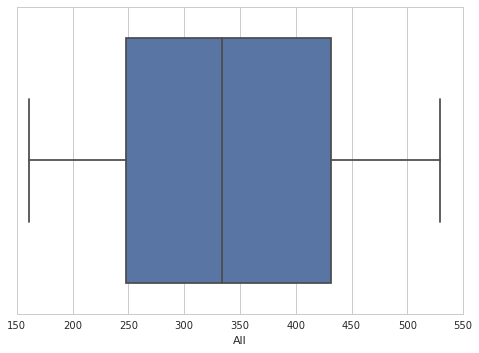

In [28]:
sns.set(style="whitegrid")
sns.boxplot(x=rest_df["All"][1:-9947])
plt.show()

##### Highlighting the cases when a restaurant has made atleast 10 orders and the number of times an order resulted in an unsettled bill is greater than the number of the times it resulted in a bill that was settled

In [29]:
rest_df = rest_df.drop(['All'],axis = 0)
rest_df = pd.DataFrame(rest_df.apply(lambda x: x[1] > x[0] and x['All'] > 10,axis = 1))
rest_df.head()

,0
restaurant_uuid,
e3601a3c-a9de-46e4-95a8-5ecd0793a274,True
a4f64f65-effd-4c81-b50d-dd81ee6333c1,True
56a90772-95a8-4811-863c-98ea61aaee00,True
3664accb-d989-4201-82b4-9bb539f0cba9,True
aa2b8fe4-0cfa-4da3-98e7-3ea60991bfeb,True


In [30]:
#The truth value here validates the condition

rest_df[0].value_counts()

False    9586
True      364
Name: 0, dtype: int64

In [31]:
#creating a copy of the original data set which will hold all the engineered features
data_mod = pd.DataFrame(data)
#merging the rest_uuid modified truth table column with the dataset 
data_mod = pd.merge(data_mod,rest_df,on = 'restaurant_uuid',how = 'inner')
data_mod = data_mod.rename(columns = {0:'rest_uuid_modified'})
data_mod.shape

(40000, 36)

#### Common patterns of observed fraud are when the mobile_country_id is not from India and the signup city is different from primary city or the trip city. The following features are aimed at proving that

In [32]:
data_mod['mob_country_id=77'] = data['mobile_country_id'] == 77
data_mod['signup_city_id=primary_city_id'] = data['signup_city_id'] == data['primary_city_id']
data_mod['signup_city_id=city_id']= data['city_id'] == data['signup_city_id'] 
#data_mod['cardtype=tokentype'] = data['card_type.1'] == data['token_type']

data_mod.shape

(40000, 39)

#### EDA on signup_app_version. We are trying to check how many of these signup_app_versions have been involved with fraud and how they rank up. This could potentially tell us which app_versions had loop holes and a higher potetial for fraud. The fix could be to force updates on users still having this versions


In [33]:
#mode(data['signup_app_version'])
data['signup_app_version'].value_counts().head(10)

1.204.10003    1421
1.180.10002    1313
1.205.10005    1110
1.171.10000     847
1.201.10003     633
1.175.10001     571
1.176.10001     505
1.173.10002     471
1.163.10001     410
1.196.10002     388
Name: signup_app_version, dtype: int64

In [34]:
signup_df = pd.DataFrame(pd.crosstab(data['signup_app_version'],data['ArrearStatus'],margins = True))
signup_df = signup_df.sort_values(['All'],ascending = False)
signup_df.head(100)

ArrearStatus,0,1,All
signup_app_version,,,
All,18153,18459,36612
1.204.10003,410,1011,1421
1.180.10002,637,676,1313
1.205.10005,285,825,1110
1.171.10000,430,417,847
1.201.10003,232,401,633
1.175.10001,278,293,571
1.176.10001,230,275,505
1.173.10002,220,251,471


##### Highlighting all the cases where the number of app_versions which resulted in a fraudulent activity is greater than non fraud app_versions

In [35]:
signup_df = signup_df.drop(['All'],axis = 0)
signup_df = pd.DataFrame(signup_df.apply(lambda x : x[1] > x[0],axis= 1))
signup_df.head(100)

,0
signup_app_version,
1.204.10003,True
1.180.10002,True
1.205.10005,True
1.171.10000,False
1.201.10003,True
1.175.10001,True
1.176.10001,True
1.173.10002,True
1.163.10001,False


In [36]:
#merging the modified data to the data set

data_mod = pd.merge(data_mod,signup_df,on = 'signup_app_version',how = 'left')
data_mod = data_mod.rename(columns = {0 : 'signup_app_version_modified'})
data_mod.shape


(40000, 40)

#### EDA on eater trip ranks. To check if fraudsters start taking invalid trips after a threshold/ to check how many times is the first order ending up in arrears. This feature tries to throw light on eater rank correlated with fraud activity

In [37]:
#mode(data['eater_trip_rank'])
df = pd.DataFrame(data['eater_trip_rank'].value_counts())
df.head(10)

,eater_trip_rank
1,1749
2,1218
3,1046
4,988
5,835
6,809
7,729
9,650
8,645
10,627


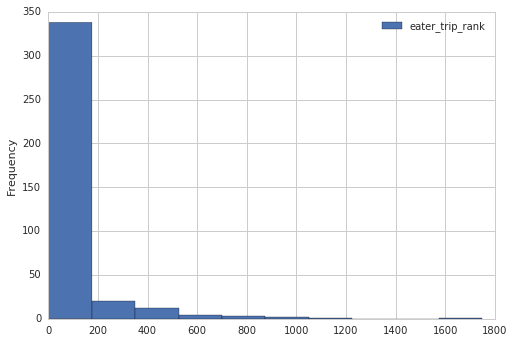

In [38]:
#distibution of trip ranks
df.plot.hist(by = 'eater_trip_rank',bins = 10)
plt.show()

In [39]:
etr_df = pd.DataFrame(pd.crosstab(data['eater_trip_rank'],data['ArrearStatus'],margins = True))
etr_df = etr_df.sort_values(['All'],ascending = False)
etr_df.head(10)

ArrearStatus,0,1,All
eater_trip_rank,,,
All,19330,7363,26693
1,983,766,1749
2,803,415,1218
3,694,352,1046
4,649,339,988
5,567,268,835
6,571,238,809
7,537,192,729
9,489,161,650


#### highlighting the cases where the fraud percentage associated with each trip rank is greater than 30

In [40]:
etr_df = etr_df.drop(['All'],axis = 0)
etr_df = pd.DataFrame(etr_df.apply(lambda x : (x[1]/x['All'])*100 > 30,axis = 1))
etr_df.head(10)

,0
eater_trip_rank,
1,True
2,True
3,True
4,True
5,True
6,False
7,False
9,False
8,True


In [41]:
#merging the new feature to the data set
data_mod = pd.merge(data_mod,etr_df,on = 'eater_trip_rank',how = 'left')
data_mod = data_mod.rename(columns = {0 : 'etr_fraud_perc_>_30'})
data_mod.shape


(40000, 41)

### Performing EDA on event timestamps. The Goal here is to throw light on any time intervals that are most frequent for a fraudster


In [42]:
#format converting function
def timestamp_converter(feature_a,feature_b,time_unit,datetimeFormat):
    if time_unit == 'days':
        units = 86400
    elif time_unit == 'hours':
        units = 3600
    elif time_unit == 'minutes':
        units = 60
    elif time_unit == 'seconds':
        units = 1
    a = []
    if datetimeFormat == 'a':
        for i in range(len(data)):
            datetimeFormat = '%Y-%m-%d %H:%M:%S.%f'
            difference = (datetime.datetime.strptime(feature_a[i],datetimeFormat)\
                              - datetime.datetime.strptime(feature_b[i],datetimeFormat))
            a.append(round(abs(difference.days *24*60*60 + difference.seconds)/units,4))
            
    elif datetimeFormat == 'b':
        for i in range(len(data)):
            datetimeFormat_1 = '%Y-%m-%d %H:%M:%S'
            datetimeFormat_2 = '%Y-%m-%d %H:%M:%S.%f'
            difference = (datetime.datetime.strptime(feature_a[i],datetimeFormat_1)\
                              - datetime.datetime.strptime(feature_b[i],datetimeFormat_2))
            a.append(round(abs(difference.days *24*60*60 + difference.seconds)/units,4))
            
            
    return a
    

#### Calculating the time interval differences for every event

In [43]:
#remember to change the units in the feature name as well
data_mod['singup_to_first_login_diff_hours'] = timestamp_converter(data['signup_timestamp'],data['first_eats_login_timestamp'],'hours','a')
data_mod['login_to_activity_diff_seconds'] = timestamp_converter(data['first_eats_login_timestamp'],data['first_eats_activity_timestamp'],'seconds','a')
data_mod['activity_to_request_diff_days'] = timestamp_converter(data['first_eats_activity_timestamp'],data['eater_request_timestamp_local'],'days','a')
data_mod['signup_to_request_diff_days'] = timestamp_converter(data['signup_timestamp'],data['eater_request_timestamp_local'],'days','a')
data_mod['first_try_to_request_timestamp_seconds'] = timestamp_converter(data['first_try_txn_timestamp'],data['eater_request_timestamp_local'],'seconds','b')
data_mod.head(100)

,rider_risk_user_segment_name,restaurant_uuid,first_try_txn_timestamp,signup_timestamp,first_eats_login_timestamp,first_eats_activity_timestamp,eater_request_timestamp_local,city_id,acct_age,request_pp_age,cg_tag,token_type,card_type.1,unsettled_7d_count,refund_count,delivery_vehicle_view_id,meal_subtotal_local,count_skus,count_distinct_skus,eater_device,eater_trip_rank,is_scheduled_order,signup_role,is_polymorphed,is_rider,mobile_country_id,has_confirmed_mobile,language_code,signup_city_id,signup_form,signup_app_version,eater_promotion_code,is_referral,primary_city_id,ArrearStatus,rest_uuid_modified,mob_country_id=77,signup_city_id=primary_city_id,signup_city_id=city_id,signup_app_version_modified,etr_fraud_perc_>_30,singup_to_first_login_diff_hours,login_to_activity_diff_seconds,activity_to_request_diff_days,signup_to_request_diff_days,first_try_to_request_timestamp_seconds
0,power,c2a645c0-e045-4250-9e97-e8a936e8e61c,2019-06-11 17:22:35,2018-07-30 15:22:37.000,2018-11-24 11:44:56.000,2018-11-24 11:44:56.000,2019-06-11 22:27:00.000,476,90d+,90d+,NON-CG,cash,cash,1,0,20003683,106,1,1,android,18,False,client,True,True,77,yes,en,949,android_passwordless,4.220.10001,eats-kumarir844ue,False,476,1,True,True,False,False,True,False,14932.3178,0.0,499.3126,1121.4925,18328.0
1,super_new,c2a645c0-e045-4250-9e97-e8a936e8e61c,2019-06-18 18:03:16,2019-06-03 15:58:31.000,2019-06-03 15:58:34.000,2019-06-03 15:58:31.000,2019-06-18 22:50:21.000,476,<= 30d,<= 30d,NON-CG,cash,cash,0,0,20003683,106.0,1,1,android,4,False,client,False,False,77,yes,en-GB,476,eats_android,1.202.10004,eats-dmaqcz,False,476,1,True,True,False,False,True,True,436.0764,0.0,167.2388,185.4087,17581.0
2,super_new,c2a645c0-e045-4250-9e97-e8a936e8e61c,2019-06-18 18:03:16,2019-06-03 15:58:31.000,2019-06-03 15:58:34.000,2019-06-03 15:58:31.000,2019-06-18 22:50:21.000,476,<= 30d,<= 30d,NON-CG,cash,cash,0,0,20003683,106.0,1,1,android,4,False,client,False,False,77,yes,en-GB,476,eats_android,1.202.10004,eats-dmaqcz,False,476,1,True,True,False,False,True,True,19992.5344,0.0,235.0646,1068.0869,18487.0
3,super_new,c2a645c0-e045-4250-9e97-e8a936e8e61c,2019-06-14 07:13:35,2019-04-26 08:16:49.000,2019-05-13 09:16:53.000,2019-05-13 09:16:53.000,2019-06-14 12:26:08.000,476,<= 90d,<= 3d,NON-CG,cash,cash,0,0,20003683,106,1,1,android,NaN,False,client,True,True,77,yes,en-GB,476,android_passwordless,4.259.10002,eats-1gqflt,False,476,1,True,True,False,False,True,NaN,6695.3594,0.0,165.0931,444.0664,16917.0
4,power,c2a645c0-e045-4250-9e97-e8a936e8e61c,2019-06-10 14:58:18,2016-01-29 13:46:34.000,2019-02-11 14:30:03.000,2019-02-11 14:30:03.000,2019-06-10 19:44:33.000,476,90d+,90d+,NON-CG,cash,cash,1,0,20003683,0.0,1,1,android,NaN,False,client,True,True,77,yes,en-GB,NaN,android,3.86.5,eats-avikp105ue,True,476,1,True,True,False,False,False,NaN,0.0061,22.0,211.4346,211.4346,17934.0
5,power,c2a645c0-e045-4250-9e97-e8a936e8e61c,2019-06-12 17:21:50,2018-09-11 04:12:14.000,2018-09-24 09:35:02.000,2018-09-24 09:35:02.000,2019-06-12 22:02:42.000,476,90d+,90d+,NON-CG,paytm,paytm,0,0,20003683,106,1,1,android,31,False,client,True,True,77,yes,en,476,arch_website,NaN,eats-misbahulm93ui,False,476,0,True,True,False,False,NaN,False,12859.7211,0.0,345.3520,881.1737,16390.0
6,NaN,c2a645c0-e045-4250-9e97-e8a936e8e61c,2019-06-17 16:43:01,2017-09-23 17:49:48.000,2019-04-14 08:15:56.000,2019-04-14 08:15:56.000,2019-06-17 21:17:35.000,476,NaN,NaN,NaN,cash,cash,0,0,20003683,106,1,1,android,4,False,partner,True,True,77,yes,en,197,website_app,NaN,eats-malayg464ue,False,476,0,True,True,False,False,NaN,True,0.0264,95.0,264.1653,264.1653,18662.0
7,new,c2a645c0-e045-4250-9e97-e8a936e8e61c,2019-06-10 09:42:40,2018-06-03 15:33:38.000,2018-12-23 08:07:40.000,2018-12-23 08:07:40.000,2019-06-10 14:44:54.000,476,90d+,90d+,NON-CG,cash,cash,1,0,20003683,223,2,2,android,NaN,False,partner,True,True,77,yes,en,476,android_passwordless,4.212.10002,eats-jayishas5ue,False,476,1,True,True,False,False,True,NaN,17477.2303,0.0,3.9643,732.1822,16725

#### Bucketing the time interval differences for each of the features so that we get a gist of what time spans to look for and it becomes to predict an interval later on

### signup_to_first_login_diff_hours

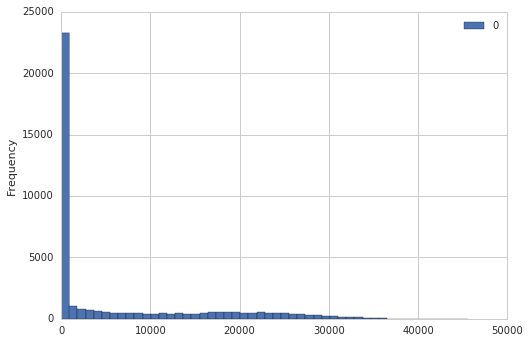

In [44]:
#

signup_to_first_login_diff_hours = pd.DataFrame(timestamp_converter(data['signup_timestamp'],data['first_eats_login_timestamp'],'hours','a'))
signup_to_first_login_diff_hours.plot.hist(bins = 50)
plt.show()

In [45]:
bins = [0,100,200,500,700,1000,2000,50000] 
groups = ['0-100','100-200','200-500','500-700','700-1000','1000-2000','2000+']

In [46]:
data_mod['singup_to_first_login_diff_hours'] = pd.cut(signup_to_first_login_diff_hours[0],bins,labels = groups,include_lowest =True)
data_mod.head()

,rider_risk_user_segment_name,restaurant_uuid,first_try_txn_timestamp,signup_timestamp,first_eats_login_timestamp,first_eats_activity_timestamp,eater_request_timestamp_local,city_id,acct_age,request_pp_age,cg_tag,token_type,card_type.1,unsettled_7d_count,refund_count,delivery_vehicle_view_id,meal_subtotal_local,count_skus,count_distinct_skus,eater_device,eater_trip_rank,is_scheduled_order,signup_role,is_polymorphed,is_rider,mobile_country_id,has_confirmed_mobile,language_code,signup_city_id,signup_form,signup_app_version,eater_promotion_code,is_referral,primary_city_id,ArrearStatus,rest_uuid_modified,mob_country_id=77,signup_city_id=primary_city_id,signup_city_id=city_id,signup_app_version_modified,etr_fraud_perc_>_30,singup_to_first_login_diff_hours,login_to_activity_diff_seconds,activity_to_request_diff_days,signup_to_request_diff_days,first_try_to_request_timestamp_seconds
0,power,c2a645c0-e045-4250-9e97-e8a936e8e61c,2019-06-11 17:22:35,2018-07-30 15:22:37.000,2018-11-24 11:44:56.000,2018-11-24 11:44:56.000,2019-06-11 22:27:00.000,476,90d+,90d+,NON-CG,cash,cash,1,0,20003683,106,1,1,android,18,False,client,True,True,77,yes,en,949,android_passwordless,4.220.10001,eats-kumarir844ue,False,476,1,True,True,False,False,True,False,2000+,0.0,499.3126,1121.4925,18328.0
1,super_new,c2a645c0-e045-4250-9e97-e8a936e8e61c,2019-06-18 18:03:16,2019-06-03 15:58:31.000,2019-06-03 15:58:34.000,2019-06-03 15:58:31.000,2019-06-18 22:50:21.000,476,<= 30d,<= 30d,NON-CG,cash,cash,0,0,20003683,106.0,1,1,android,4,False,client,False,False,77,yes,en-GB,476,eats_android,1.202.10004,eats-dmaqcz,False,476,1,True,True,False,False,True,True,200-500,0.0,167.2388,185.4087,17581.0
2,super_new,c2a645c0-e045-4250-9e97-e8a936e8e61c,2019-06-18 18:03:16,2019-06-03 15:58:31.000,2019-06-03 15:58:34.000,2019-06-03 15:58:31.000,2019-06-18 22:50:21.000,476,<= 30d,<= 30d,NON-CG,cash,cash,0,0,20003683,106.0,1,1,android,4,False,client,False,False,77,yes,en-GB,476,eats_android,1.202.10004,eats-dmaqcz,False,476,1,True,True,False,False,True,True,2000+,0.0,235.0646,1068.0869,18487.0
3,super_new,c2a645c0-e045-4250-9e97-e8a936e8e61c,2019-06-14 07:13:35,2019-04-26 08:16:49.000,2019-05-13 09:16:53.000,2019-05-13 09:16:53.000,2019-06-14 12:26:08.000,476,<= 90d,<= 3d,NON-CG,cash,cash,0,0,20003683,106,1,1,android,NaN,False,client,True,True,77,yes,en-GB,476,android_passwordless,4.259.10002,eats-1gqflt,False,476,1,True,True,False,False,True,NaN,2000+,0.0,165.0931,444.0664,16917.0
4,power,c2a645c0-e045-4250-9e97-e8a936e8e61c,2019-06-10 14:58:18,2016-01-29 13:46:34.000,2019-02-11 14:30:03.000,2019-02-11 14:30:03.000,2019-06-10 19:44:33.000,476,90d+,90d+,NON-CG,cash,cash,1,0,20003683,0.0,1,1,android,NaN,False,client,True,True,77,yes,en-GB,NaN,android,3.86.5,eats-avikp105ue,True,476,1,True,True,False,False,False,NaN,0-100,22.0,211.4346,211.4346,17934.0


### login_to_activity_diff_seconds

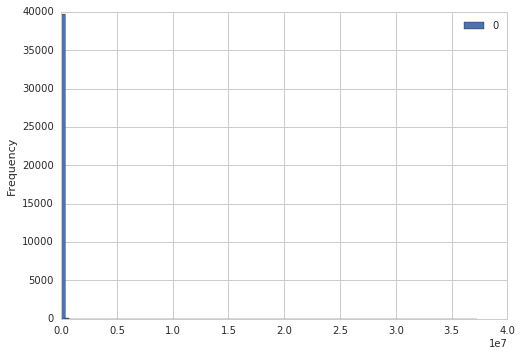

In [47]:
#

login_to_activity_diff_seconds = pd.DataFrame(timestamp_converter(data['first_eats_login_timestamp'],data['first_eats_activity_timestamp'],'seconds','a'))
login_to_activity_diff_seconds.plot.hist(bins = 100)
plt.show()                                         

In [48]:
bins = [0,100,200,500,700,1000,2000,50000] 
groups = ['0-100','100-200','200-500','500-700','700-1000','1000-2000','2000+']

In [49]:
data_mod['login_to_activity_diff_seconds'] =  pd.cut(login_to_activity_diff_seconds[0],bins,labels = groups,include_lowest =True)


In [50]:
data_mod['login_to_activity_diff_seconds'].value_counts()

0-100        35249
100-200       2564
200-500       1142
2000+          255
500-700        128
1000-2000      104
700-1000        85
Name: login_to_activity_diff_seconds, dtype: int64

In [51]:
data_mod.head()

,rider_risk_user_segment_name,restaurant_uuid,first_try_txn_timestamp,signup_timestamp,first_eats_login_timestamp,first_eats_activity_timestamp,eater_request_timestamp_local,city_id,acct_age,request_pp_age,cg_tag,token_type,card_type.1,unsettled_7d_count,refund_count,delivery_vehicle_view_id,meal_subtotal_local,count_skus,count_distinct_skus,eater_device,eater_trip_rank,is_scheduled_order,signup_role,is_polymorphed,is_rider,mobile_country_id,has_confirmed_mobile,language_code,signup_city_id,signup_form,signup_app_version,eater_promotion_code,is_referral,primary_city_id,ArrearStatus,rest_uuid_modified,mob_country_id=77,signup_city_id=primary_city_id,signup_city_id=city_id,signup_app_version_modified,etr_fraud_perc_>_30,singup_to_first_login_diff_hours,login_to_activity_diff_seconds,activity_to_request_diff_days,signup_to_request_diff_days,first_try_to_request_timestamp_seconds
0,power,c2a645c0-e045-4250-9e97-e8a936e8e61c,2019-06-11 17:22:35,2018-07-30 15:22:37.000,2018-11-24 11:44:56.000,2018-11-24 11:44:56.000,2019-06-11 22:27:00.000,476,90d+,90d+,NON-CG,cash,cash,1,0,20003683,106,1,1,android,18,False,client,True,True,77,yes,en,949,android_passwordless,4.220.10001,eats-kumarir844ue,False,476,1,True,True,False,False,True,False,2000+,0-100,499.3126,1121.4925,18328.0
1,super_new,c2a645c0-e045-4250-9e97-e8a936e8e61c,2019-06-18 18:03:16,2019-06-03 15:58:31.000,2019-06-03 15:58:34.000,2019-06-03 15:58:31.000,2019-06-18 22:50:21.000,476,<= 30d,<= 30d,NON-CG,cash,cash,0,0,20003683,106.0,1,1,android,4,False,client,False,False,77,yes,en-GB,476,eats_android,1.202.10004,eats-dmaqcz,False,476,1,True,True,False,False,True,True,200-500,0-100,167.2388,185.4087,17581.0
2,super_new,c2a645c0-e045-4250-9e97-e8a936e8e61c,2019-06-18 18:03:16,2019-06-03 15:58:31.000,2019-06-03 15:58:34.000,2019-06-03 15:58:31.000,2019-06-18 22:50:21.000,476,<= 30d,<= 30d,NON-CG,cash,cash,0,0,20003683,106.0,1,1,android,4,False,client,False,False,77,yes,en-GB,476,eats_android,1.202.10004,eats-dmaqcz,False,476,1,True,True,False,False,True,True,2000+,0-100,235.0646,1068.0869,18487.0
3,super_new,c2a645c0-e045-4250-9e97-e8a936e8e61c,2019-06-14 07:13:35,2019-04-26 08:16:49.000,2019-05-13 09:16:53.000,2019-05-13 09:16:53.000,2019-06-14 12:26:08.000,476,<= 90d,<= 3d,NON-CG,cash,cash,0,0,20003683,106,1,1,android,NaN,False,client,True,True,77,yes,en-GB,476,android_passwordless,4.259.10002,eats-1gqflt,False,476,1,True,True,False,False,True,NaN,2000+,0-100,165.0931,444.0664,16917.0
4,power,c2a645c0-e045-4250-9e97-e8a936e8e61c,2019-06-10 14:58:18,2016-01-29 13:46:34.000,2019-02-11 14:30:03.000,2019-02-11 14:30:03.000,2019-06-10 19:44:33.000,476,90d+,90d+,NON-CG,cash,cash,1,0,20003683,0.0,1,1,android,NaN,False,client,True,True,77,yes,en-GB,NaN,android,3.86.5,eats-avikp105ue,True,476,1,True,True,False,False,False,NaN,0-100,0-100,211.4346,211.4346,17934.0


### activity_to_request_diff_days

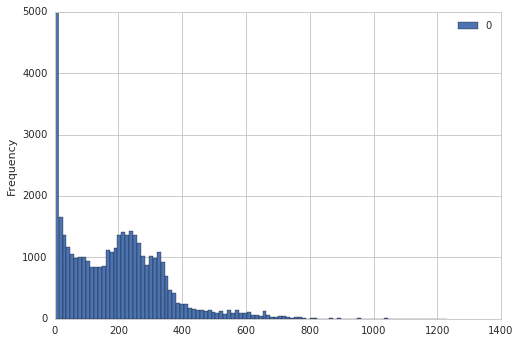

In [52]:
#
activity_to_request_diff_days = pd.DataFrame(timestamp_converter(data['first_eats_activity_timestamp'],data['eater_request_timestamp_local'],'days','a'))
activity_to_request_diff_days.plot.hist(bins = 100)
plt.show()

In [53]:
bins = [0,10,30,100,200,250,300,400,600,1400] 
groups = ['0-10','10-30','100-200','200-250','250-300','300-400','400-600','600-1400','1400+']

In [54]:
data_mod['activity_to_request_diff_days'] = pd.cut(activity_to_request_diff_days[0],bins,labels = groups,include_lowest =True)
data_mod['activity_to_request_diff_days'].value_counts()

200-250     7934
100-200     6080
250-300     5677
400-600     5619
0-10        4555
300-400     4424
10-30       2706
600-1400    2185
1400+        820
Name: activity_to_request_diff_days, dtype: int64

In [55]:
#data_mod.head()
df = pd.DataFrame(pd.crosstab(data_mod['activity_to_request_diff_days'],data_mod['ArrearStatus'],margins = True))
df.apply(lambda x : x[1]/x['All'],axis = 1)

activity_to_request_diff_days
600-1400    0.496378
200-250     0.515152
250-300     0.501151
400-600     0.502773
300-400     0.507486
0-10        0.503165
10-30       0.491725
100-200     0.478261
1400+       0.480488
All         0.500000
dtype: float64

### signup_to_request_diff_days

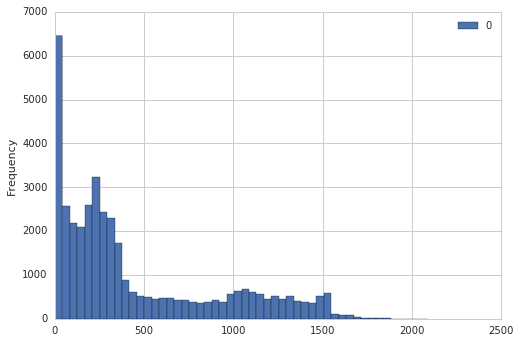

In [56]:

signup_to_request_diff_days = pd.DataFrame(timestamp_converter(data['signup_timestamp'],data['eater_request_timestamp_local'],'days','a'))
signup_to_request_diff_days.plot.hist(bins = 50)
plt.show()

In [57]:
bins = [0,10,100,250,400,1000,2500] 
groups = ['0-10','10-100','100-250','250-400','400-1000','1000-2500']

In [58]:
data_mod['signup_to_request_diff_days'] = pd.cut(signup_to_request_diff_days[0],bins,labels = groups,include_lowest =True)

In [59]:
df = pd.DataFrame(pd.crosstab(data_mod['signup_to_request_diff_days'],data_mod['ArrearStatus'],margins = True))
df.apply(lambda x : x[1]/x['All'],axis = 1)

signup_to_request_diff_days
1000-2500    0.497602
100-250      0.511017
400-1000     0.500164
250-400      0.494765
10-100       0.500823
0-10         0.495546
All          0.500000
dtype: float64

### first_try_to_request_timestamp_seconds

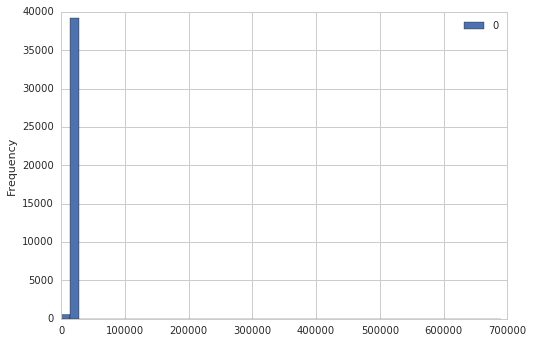

In [60]:
first_try_to_request_timestamp_seconds = pd.DataFrame(timestamp_converter(data['first_try_txn_timestamp'],data['eater_request_timestamp_local'],'seconds','b'))
first_try_to_request_timestamp_seconds.plot.hist(bins = 50)

#data_mod.boxplot(column ='first_try_to_request_timestamp_seconds' )
plt.show()

In [61]:
bins = [0,17000,18000,19000,20000,700000] 
groups = ['0-17000','17000-18000','18000-19000','19000-20000','20000+']

In [62]:
data_mod['first_try_to_request_timestamp_seconds'] = pd.cut(first_try_to_request_timestamp_seconds[0],bins,labels = groups,include_lowest =True)

In [63]:
data_mod['first_try_to_request_timestamp_seconds'].value_counts()

17000-18000    13441
18000-19000    12590
0-17000         7725
19000-20000     5983
20000+           261
Name: first_try_to_request_timestamp_seconds, dtype: int64

In [64]:
df = pd.DataFrame(pd.crosstab(data_mod['first_try_to_request_timestamp_seconds'],data_mod['ArrearStatus'],margins = True))
df.apply(lambda x : x[1]/x['All'],axis = 1)

first_try_to_request_timestamp_seconds
18000-19000    0.512492
17000-18000    0.503013
0-17000        0.491819
19000-20000    0.494735
20000+         0.490421
All            0.500000
dtype: float64

In [65]:
data_mod.head()

,rider_risk_user_segment_name,restaurant_uuid,first_try_txn_timestamp,signup_timestamp,first_eats_login_timestamp,first_eats_activity_timestamp,eater_request_timestamp_local,city_id,acct_age,request_pp_age,cg_tag,token_type,card_type.1,unsettled_7d_count,refund_count,delivery_vehicle_view_id,meal_subtotal_local,count_skus,count_distinct_skus,eater_device,eater_trip_rank,is_scheduled_order,signup_role,is_polymorphed,is_rider,mobile_country_id,has_confirmed_mobile,language_code,signup_city_id,signup_form,signup_app_version,eater_promotion_code,is_referral,primary_city_id,ArrearStatus,rest_uuid_modified,mob_country_id=77,signup_city_id=primary_city_id,signup_city_id=city_id,signup_app_version_modified,etr_fraud_perc_>_30,singup_to_first_login_diff_hours,login_to_activity_diff_seconds,activity_to_request_diff_days,signup_to_request_diff_days,first_try_to_request_timestamp_seconds
0,power,c2a645c0-e045-4250-9e97-e8a936e8e61c,2019-06-11 17:22:35,2018-07-30 15:22:37.000,2018-11-24 11:44:56.000,2018-11-24 11:44:56.000,2019-06-11 22:27:00.000,476,90d+,90d+,NON-CG,cash,cash,1,0,20003683,106,1,1,android,18,False,client,True,True,77,yes,en,949,android_passwordless,4.220.10001,eats-kumarir844ue,False,476,1,True,True,False,False,True,False,2000+,0-100,600-1400,1000-2500,18000-19000
1,super_new,c2a645c0-e045-4250-9e97-e8a936e8e61c,2019-06-18 18:03:16,2019-06-03 15:58:31.000,2019-06-03 15:58:34.000,2019-06-03 15:58:31.000,2019-06-18 22:50:21.000,476,<= 30d,<= 30d,NON-CG,cash,cash,0,0,20003683,106.0,1,1,android,4,False,client,False,False,77,yes,en-GB,476,eats_android,1.202.10004,eats-dmaqcz,False,476,1,True,True,False,False,True,True,200-500,0-100,200-250,100-250,17000-18000
2,super_new,c2a645c0-e045-4250-9e97-e8a936e8e61c,2019-06-18 18:03:16,2019-06-03 15:58:31.000,2019-06-03 15:58:34.000,2019-06-03 15:58:31.000,2019-06-18 22:50:21.000,476,<= 30d,<= 30d,NON-CG,cash,cash,0,0,20003683,106.0,1,1,android,4,False,client,False,False,77,yes,en-GB,476,eats_android,1.202.10004,eats-dmaqcz,False,476,1,True,True,False,False,True,True,2000+,0-100,250-300,1000-2500,18000-19000
3,super_new,c2a645c0-e045-4250-9e97-e8a936e8e61c,2019-06-14 07:13:35,2019-04-26 08:16:49.000,2019-05-13 09:16:53.000,2019-05-13 09:16:53.000,2019-06-14 12:26:08.000,476,<= 90d,<= 3d,NON-CG,cash,cash,0,0,20003683,106,1,1,android,NaN,False,client,True,True,77,yes,en-GB,476,android_passwordless,4.259.10002,eats-1gqflt,False,476,1,True,True,False,False,True,NaN,2000+,0-100,200-250,400-1000,0-17000
4,power,c2a645c0-e045-4250-9e97-e8a936e8e61c,2019-06-10 14:58:18,2016-01-29 13:46:34.000,2019-02-11 14:30:03.000,2019-02-11 14:30:03.000,2019-06-10 19:44:33.000,476,90d+,90d+,NON-CG,cash,cash,1,0,20003683,0.0,1,1,android,NaN,False,client,True,True,77,yes,en-GB,NaN,android,3.86.5,eats-avikp105ue,True,476,1,True,True,False,False,False,NaN,0-100,0-100,250-300,100-250,17000-18000


### EDA on meal_subtotal_local
#### To understand if there is a pattern in the order value that the fraudulent eaters are choosing 

In [66]:

data_mod['meal_subtotal_local'].value_counts().head(10)

0      1305
120     925
100     879
90      723
80      718
110     681
130     475
99      465
140     465
160     436
Name: meal_subtotal_local, dtype: int64

In [67]:
meal_df = pd.DataFrame(pd.crosstab(data_mod['meal_subtotal_local'],data_mod['ArrearStatus'],margins = True))
meal_df = meal_df.sort_values(['All'],ascending = False)
meal_df.head(10)

ArrearStatus,0,1,All
meal_subtotal_local,,,
All,19408,19975,39383
0,359,946,1305
120,585,340,925
100,605,274,879
90,522,201,723
80,526,192,718
110,447,234,681
130,304,171,475
99,313,152,465


In [68]:
#highlighting all the cases where the number of number of orders 
#with that amount is greater than 10 and the percentage of fraud 
#from that order amount is > 70% 
meal_df = pd.DataFrame(meal_df.apply(lambda x : x[1]/x['All'] > .7 and x['All'] >= 10,axis = 1))
meal_df.head(10)

,0
meal_subtotal_local,
All,False
0,True
120,False
100,False
90,False
80,False
110,False
130,False
99,False


In [69]:
#values recovered from the condition
meal_df[0].value_counts()

False    4101
True      155
Name: 0, dtype: int64

In [70]:
#merging the new data
data_mod = pd.merge(data_mod,meal_df,on = 'meal_subtotal_local',how = 'left')
data_mod = data_mod.rename(columns = {0 : 'meal_subtotal_local_modified'})
data_mod.head()

,rider_risk_user_segment_name,restaurant_uuid,first_try_txn_timestamp,signup_timestamp,first_eats_login_timestamp,first_eats_activity_timestamp,eater_request_timestamp_local,city_id,acct_age,request_pp_age,cg_tag,token_type,card_type.1,unsettled_7d_count,refund_count,delivery_vehicle_view_id,meal_subtotal_local,count_skus,count_distinct_skus,eater_device,eater_trip_rank,is_scheduled_order,signup_role,is_polymorphed,is_rider,mobile_country_id,has_confirmed_mobile,language_code,signup_city_id,signup_form,signup_app_version,eater_promotion_code,is_referral,primary_city_id,ArrearStatus,rest_uuid_modified,mob_country_id=77,signup_city_id=primary_city_id,signup_city_id=city_id,signup_app_version_modified,etr_fraud_perc_>_30,singup_to_first_login_diff_hours,login_to_activity_diff_seconds,activity_to_request_diff_days,signup_to_request_diff_days,first_try_to_request_timestamp_seconds,meal_subtotal_local_modified
0,power,c2a645c0-e045-4250-9e97-e8a936e8e61c,2019-06-11 17:22:35,2018-07-30 15:22:37.000,2018-11-24 11:44:56.000,2018-11-24 11:44:56.000,2019-06-11 22:27:00.000,476,90d+,90d+,NON-CG,cash,cash,1,0,20003683,106,1,1,android,18,False,client,True,True,77,yes,en,949,android_passwordless,4.220.10001,eats-kumarir844ue,False,476,1,True,True,False,False,True,False,2000+,0-100,600-1400,1000-2500,18000-19000,False
1,super_new,c2a645c0-e045-4250-9e97-e8a936e8e61c,2019-06-18 18:03:16,2019-06-03 15:58:31.000,2019-06-03 15:58:34.000,2019-06-03 15:58:31.000,2019-06-18 22:50:21.000,476,<= 30d,<= 30d,NON-CG,cash,cash,0,0,20003683,106.0,1,1,android,4,False,client,False,False,77,yes,en-GB,476,eats_android,1.202.10004,eats-dmaqcz,False,476,1,True,True,False,False,True,True,200-500,0-100,200-250,100-250,17000-18000,True
2,super_new,c2a645c0-e045-4250-9e97-e8a936e8e61c,2019-06-18 18:03:16,2019-06-03 15:58:31.000,2019-06-03 15:58:34.000,2019-06-03 15:58:31.000,2019-06-18 22:50:21.000,476,<= 30d,<= 30d,NON-CG,cash,cash,0,0,20003683,106.0,1,1,android,4,False,client,False,False,77,yes,en-GB,476,eats_android,1.202.10004,eats-dmaqcz,False,476,1,True,True,False,False,True,True,2000+,0-100,250-300,1000-2500,18000-19000,True
3,super_new,c2a645c0-e045-4250-9e97-e8a936e8e61c,2019-06-14 07:13:35,2019-04-26 08:16:49.000,2019-05-13 09:16:53.000,2019-05-13 09:16:53.000,2019-06-14 12:26:08.000,476,<= 90d,<= 3d,NON-CG,cash,cash,0,0,20003683,106,1,1,android,NaN,False,client,True,True,77,yes,en-GB,476,android_passwordless,4.259.10002,eats-1gqflt,False,476,1,True,True,False,False,True,NaN,2000+,0-100,200-250,400-1000,0-17000,False
4,power,c2a645c0-e045-4250-9e97-e8a936e8e61c,2019-06-10 14:58:18,2016-01-29 13:46:34.000,2019-02-11 14:30:03.000,2019-02-11 14:30:03.000,2019-06-10 19:44:33.000,476,90d+,90d+,NON-CG,cash,cash,1,0,20003683,0.0,1,1,android,NaN,False,client,True,True,77,yes,en-GB,NaN,android,3.86.5,eats-avikp105ue,True,476,1,True,True,False,False,False,NaN,0-100,0-100,250-300,100-250,17000-18000,True


In [71]:
print("engineered dataset size :",data_mod.shape)

engineered dataset size : (40000, 47)


#### removing the contributors to the modified features since they wont be of use any more and will only cause noise

In [72]:

features_to_be_removed = ['restaurant_uuid','mobile_country_id','signup_app_version','eater_trip_rank',
                         'signup_timestamp','first_eats_login_timestamp','first_eats_activity_timestamp',
                          'eater_request_timestamp_local','first_try_txn_timestamp','meal_subtotal_local',
                         'eater_promotion_code']

In [73]:
data_mod = data_mod.drop(columns = features_to_be_removed)
data_mod.head()

,rider_risk_user_segment_name,city_id,acct_age,request_pp_age,cg_tag,token_type,card_type.1,unsettled_7d_count,refund_count,delivery_vehicle_view_id,count_skus,count_distinct_skus,eater_device,is_scheduled_order,signup_role,is_polymorphed,is_rider,has_confirmed_mobile,language_code,signup_city_id,signup_form,is_referral,primary_city_id,ArrearStatus,rest_uuid_modified,mob_country_id=77,signup_city_id=primary_city_id,signup_city_id=city_id,signup_app_version_modified,etr_fraud_perc_>_30,singup_to_first_login_diff_hours,login_to_activity_diff_seconds,activity_to_request_diff_days,signup_to_request_diff_days,first_try_to_request_timestamp_seconds,meal_subtotal_local_modified
0,power,476,90d+,90d+,NON-CG,cash,cash,1,0,20003683,1,1,android,False,client,True,True,yes,en,949,android_passwordless,False,476,1,True,True,False,False,True,False,2000+,0-100,600-1400,1000-2500,18000-19000,False
1,super_new,476,<= 30d,<= 30d,NON-CG,cash,cash,0,0,20003683,1,1,android,False,client,False,False,yes,en-GB,476,eats_android,False,476,1,True,True,False,False,True,True,200-500,0-100,200-250,100-250,17000-18000,True
2,super_new,476,<= 30d,<= 30d,NON-CG,cash,cash,0,0,20003683,1,1,android,False,client,False,False,yes,en-GB,476,eats_android,False,476,1,True,True,False,False,True,True,2000+,0-100,250-300,1000-2500,18000-19000,True
3,super_new,476,<= 90d,<= 3d,NON-CG,cash,cash,0,0,20003683,1,1,android,False,client,True,True,yes,en-GB,476,android_passwordless,False,476,1,True,True,False,False,True,NaN,2000+,0-100,200-250,400-1000,0-17000,False
4,power,476,90d+,90d+,NON-CG,cash,cash,1,0,20003683,1,1,android,False,client,True,True,yes,en-GB,NaN,android,True,476,1,True,True,False,False,False,NaN,0-100,0-100,250-300,100-250,17000-18000,True


In [74]:
data_mod.shape

(40000, 36)

### Checking the number of unique values in each feature

In [75]:
data_mod.apply(pd.Series.nunique,axis =0)

rider_risk_user_segment_name                5
city_id                                    38
acct_age                                    6
request_pp_age                              6
cg_tag                                      2
token_type                                  5
card_type.1                                10
unsettled_7d_count                          2
refund_count                                2
delivery_vehicle_view_id                   38
count_skus                                 39
count_distinct_skus                        10
eater_device                                3
is_scheduled_order                          2
signup_role                                 3
is_polymorphed                              2
is_rider                                    2
has_confirmed_mobile                        5
language_code                              20
signup_city_id                            132
signup_form                                20
is_referral                       

In [76]:
#(done) imputation
#(done) encoding
#(done) Correlatation
#(done) feature imporatnce
#polyomical features
#(done) modeling and prediction

### Calulating missing values post data cleaning and feature engineering

In [77]:
missing_values = missing_value_columns(data_mod)
df = pd.DataFrame(missing_values)
df

,missing values,% of total values
etr_fraud_perc_>_30,13307,33.2675
request_pp_age,3969,9.9225
rider_risk_user_segment_name,3935,9.8375
acct_age,3935,9.8375
cg_tag,3890,9.7250
signup_app_version_modified,3388,8.4700
signup_form,1226,3.0650
signup_city_id,956,2.3900
delivery_vehicle_view_id,952,2.3800
meal_subtotal_local_modified,617,1.5425


### Replacing the missing values with the mode of the data 
#### Later we will use linear regression and feature ratios to fill up the missing values if required

In [78]:

data_mod['request_pp_age'].fillna(data_mod['request_pp_age'].mode()[0],inplace = True)
data_mod['rider_risk_user_segment_name'].fillna(data_mod['rider_risk_user_segment_name'].mode()[0],inplace = True)
data_mod['cg_tag'].fillna(data_mod['cg_tag'].mode()[0],inplace = True)
data_mod['acct_age'].fillna(data_mod['acct_age'].mode()[0],inplace = True)
data_mod['signup_app_version_modified'].fillna(data_mod['signup_app_version_modified'].mode()[0],inplace = True)
data_mod['signup_form'].fillna(data_mod['signup_form'].mode()[0],inplace = True)
data_mod['signup_city_id'].fillna(data_mod['signup_city_id'].mode()[0],inplace = True)
data_mod['delivery_vehicle_view_id'].fillna(data_mod['delivery_vehicle_view_id'].mode()[0],inplace = True)
data_mod['meal_subtotal_local_modified'].fillna(data_mod['meal_subtotal_local_modified'].mode()[0],inplace = True)
data_mod['login_to_activity_diff_seconds'].fillna(data_mod['login_to_activity_diff_seconds'].mode()[0],inplace = True)
data_mod['etr_fraud_perc_>_30'].fillna(data_mod['etr_fraud_perc_>_30'].mode()[0],inplace = True)



In [79]:
missing_values = missing_value_columns(data_mod)
df = pd.DataFrame(missing_values)
df

,missing values,% of total values
rider_risk_user_segment_name,0,0.0
city_id,0,0.0
signup_form,0,0.0
is_referral,0,0.0
primary_city_id,0,0.0
ArrearStatus,0,0.0
rest_uuid_modified,0,0.0
mob_country_id=77,0,0.0
signup_city_id=primary_city_id,0,0.0
signup_city_id=city_id,0,0.0


In [80]:
#data_mod['etr_fraud_perc_>_30'].value_counts() *100/len(data_mod['etr_fraud_perc_>_30'])

In [81]:
data_mod.apply(pd.Series.nunique,axis =0)
f_features = pd.DataFrame(list(data_mod.columns))
f_features.to_csv('final_features.csv')

In [82]:
data_mod.shape

(40000, 36)

### One Hot Encoding the modified data (only for columns with object dtype)

In [83]:
data_mod = pd.get_dummies(data_mod)
data_mod.shape ,data_mod.to_csv('engineered_data.csv')

((40000, 307), None)

In [84]:
data_mod.apply(pd.Series.nunique,axis =0)

city_id                                               38
unsettled_7d_count                                     2
refund_count                                           2
count_skus                                            39
count_distinct_skus                                   10
is_scheduled_order                                     2
is_polymorphed                                         2
is_rider                                               2
is_referral                                            2
primary_city_id                                       59
ArrearStatus                                           2
rest_uuid_modified                                     2
mob_country_id=77                                      2
signup_city_id=primary_city_id                         1
signup_city_id=city_id                                 1
signup_app_version_modified                            2
etr_fraud_perc_>_30                                    2
meal_subtotal_local_modified   

In [85]:
data_mod.shape

(40000, 307)

### Find correlations with the target using a pearson correlation function and sorting the values

In [86]:

correlations = data_mod.corr(method = 'pearson')['ArrearStatus']
values = round(correlations.sort_values(ascending = False),5)*100
values

ArrearStatus                                          100.000
token_type_cash                                        37.510
unsettled_7d_count                                     35.032
card_type.1_cash                                       33.528
meal_subtotal_local_modified                           31.228
rider_risk_user_segment_name_super_new                 22.198
rest_uuid_modified                                     17.071
signup_app_version_modified                            15.072
acct_age_<= 3d                                         12.248
signup_form_eats_android                               11.036
count_skus                                              7.686
cg_tag_CG                                               7.549
request_pp_age_<= 3d                                    6.761
delivery_vehicle_view_id_20010543                       6.471
acct_age_<= 7d                                          5.446
delivery_vehicle_view_id_20003675                       4.692
language

### Calculating Feature importance using a random forest classifier

In [87]:
target = data_mod['ArrearStatus']
data= data_mod.drop(columns = ['ArrearStatus'])
data.shape,target.shape

((40000, 306), (40000,))

In [88]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

#splitting the data into an 80:20 ratio
x_train,x_test,y_train,y_test = train_test_split(data,target,test_size = 0.2,random_state = 0)

#defining the feature labels
feat_labels = data.columns

In [89]:
#Creating the RF classifier
clf = RandomForestClassifier(n_estimators = 100,criterion = 'gini', 
                                       random_state = 60,bootstrap = True,oob_score = True,
                                       verbose = 1, n_jobs = -1,min_impurity_split = 1e-3,
                                      class_weight = 'balanced')

In [90]:
#training the classifier
clf.fit(x_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.8s finished


RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=0.001, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=-1, oob_score=True,
                       random_state=60, verbose=1, warm_start=False)

In [91]:
feature_importance_values = clf.feature_importances_
feature_importances = pd.DataFrame({'feature': feat_labels, 'importance_percentage': (feature_importance_values.round(5))*100.0})
feature_importances.sort_values(by = 'importance_percentage',ascending = False)



,feature,importance_percentage
1,unsettled_7d_count,6.923
16,meal_subtotal_local_modified,6.344
37,token_type_cash,5.157
15,etr_fraud_perc_>_30,4.270
3,count_skus,2.923
47,card_type.1_cash,2.805
0,city_id,2.421
9,primary_city_id,2.402
20,rider_risk_user_segment_name_super_new,2.140
40,token_type_zaakpay,2.049


### Building a neural network to calculate prediction accuracies

In [92]:
from keras.models import Sequential
from keras.layers import Dense
import numpy
# fix random seed for reproducibility
numpy.random.seed(7)


Using TensorFlow backend.


In [93]:
# create model
model = Sequential()
model.add(Dense(24, input_dim=int(x_train.shape[1]), activation='sigmoid'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [94]:
x_train.shape,y_train.shape,x_test.shape,y_test.shape

((32000, 306), (32000,), (8000, 306), (8000,))

In [95]:
y_train.value_counts()

1    16047
0    15953
Name: ArrearStatus, dtype: int64

In [96]:
y_test.value_counts()

0    4047
1    3953
Name: ArrearStatus, dtype: int64

In [97]:
# Compile model
model.compile(loss='binary_crossentropy', optimizer='adagrad', metrics=['accuracy'])

#### Fit the model

In [98]:

model.fit(x_train,y_train, epochs=15, batch_size=20)

Epoch 1/15
32000/32000 [==============================] - 4s 139us/step - loss: 0.6205 - acc: 0.6438
Epoch 2/15
32000/32000 [==============================] - 4s 136us/step - loss: 0.5204 - acc: 0.7265
Epoch 3/15
32000/32000 [==============================] - 4s 118us/step - loss: 0.4815 - acc: 0.7528
Epoch 4/15
32000/32000 [==============================] - 4s 119us/step - loss: 0.4668 - acc: 0.7627
Epoch 5/15
32000/32000 [==============================] - 4s 116us/step - loss: 0.4585 - acc: 0.7662
Epoch 6/15
32000/32000 [==============================] - 4s 129us/step - loss: 0.4540 - acc: 0.7714
Epoch 7/15
32000/32000 [==============================] - 4s 127us/step - loss: 0.4503 - acc: 0.7732
Epoch 8/15
32000/32000 [==============================] - 4s 123us/step - loss: 0.4467 - acc: 0.7748
Epoch 9/15
32000/32000 [==============================] - 4s 116us/step - loss: 0.4442 - acc: 0.7788
Epoch 10/15
32000/32000 [==============================] - 4s 114us/step - loss: 0.4426 - a

#### evaluate the model's performance

In [99]:

scores = model.evaluate(x_test, y_test)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

8000/8000 [==============================] - 0s 40us/step

acc: 78.14%


In [100]:
# calculate confusion matrix
from sklearn.metrics import confusion_matrix
y_pred = model.predict(x_test).round()

def print_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    print('True positive = ', cm[0][0])
    print('False positive = ', cm[0][1])
    print('False negative = ', cm[1][0])
    print('True negative = ', cm[1][1])
    return cm

print_confusion_matrix(y_test,y_pred)

True positive =  3506
False positive =  541
False negative =  1208
True negative =  2745


array([[3506,  541],
       [1208, 2745]])

In [101]:
def print_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tn,fp,fn,tp = cm.ravel()
    return tn,fp,fn,tp
print_confusion_matrix(y_test,y_pred)

(3506, 541, 1208, 2745)

In [102]:
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.74      0.87      0.80      4047
           1       0.84      0.69      0.76      3953

    accuracy                           0.78      8000
   macro avg       0.79      0.78      0.78      8000
weighted avg       0.79      0.78      0.78      8000



### Calculating prediction accuracy using a random forest

In [103]:
from sklearn.ensemble import RandomForestClassifier

# Make the random forest classifier
random_forest = RandomForestClassifier(n_estimators = 100,criterion = 'gini', 
                                       random_state = 60,bootstrap = True,oob_score = True,
                                       verbose = 1, n_jobs = -1,min_impurity_split = 1e-3,
                                      class_weight = 'balanced')

In [104]:
# Train on the training data
random_forest.fit(x_train, y_train)



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.4s finished


RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=0.001, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=-1, oob_score=True,
                       random_state=60, verbose=1, warm_start=False)

In [105]:
# Make predictions on the test data
#this shows the counts of different probabilities for the ArrearStatus == 1
rf_predictions_prob = pd.DataFrame(random_forest.predict_proba(x_test)[:,1]).round(3)
rf_predictions = pd.DataFrame(random_forest.predict(x_test))
rf_predictions.describe()
#rf_predictions

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


,0
count,8000.000000
mean,0.458500
std,0.498306
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


AUC: 0.797
AUC_prob: 0.882


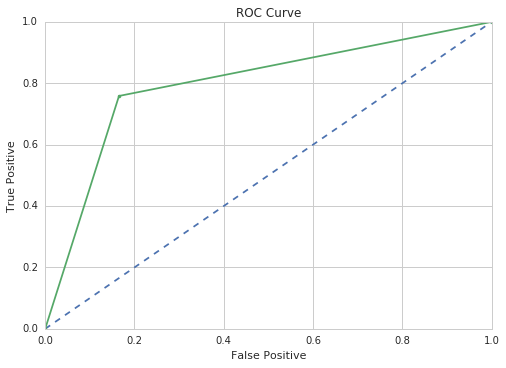

In [106]:
#plotting the ROC curve and calculating the prediction accuracy
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot
# calculate AUC
auc = roc_auc_score(y_test, rf_predictions)
auc_prob = roc_auc_score(y_test, rf_predictions_prob)
print('AUC: %.3f' % auc)
print('AUC_prob: %.3f' % auc_prob)
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, rf_predictions)
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
pyplot.plot(fpr, tpr, marker='.')
pyplot.xlabel('False Positive')
pyplot.ylabel('True Positive')
pyplot.title('ROC Curve')
pyplot.show()

In [107]:
# calculate confusion matrix
y_pred = rf_predictions

def print_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    print('True positive = ', cm[0][0])
    print('False positive = ', cm[0][1])
    print('False negative = ', cm[1][0])
    print('True negative = ', cm[1][1])

print_confusion_matrix(y_test,y_pred)

True positive =  3378
False positive =  669
False negative =  954
True negative =  2999


In [108]:
def print_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tn,fp,fn,tp = cm.ravel()
    return tn,fp,fn,tp
print_confusion_matrix(y_test,y_pred)

(3378, 669, 954, 2999)

In [109]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.78      0.83      0.81      4047
           1       0.82      0.76      0.79      3953

    accuracy                           0.80      8000
   macro avg       0.80      0.80      0.80      8000
weighted avg       0.80      0.80      0.80      8000



#### Calculating prediction accuracy using a Xtreme Gradient Boosting classifier

In [110]:
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier(n_estimators=200,max_depth=5,max_leaf_nodes=1000,
                                verbose=1,random_state=100,warm_start=True)
gb.fit(x_train,y_train)

      Iter       Train Loss   Remaining Time 
         1           1.3070            1.99m
         2           1.2420            2.01m
         3           1.1881            2.01m
         4           1.1428            2.01m
         5           1.1046            2.00m
         6           1.0719            1.99m
         7           1.0455            1.98m
         8           1.0205            1.97m
         9           1.0000            1.98m
        10           0.9807            1.97m
        20           0.8753            1.96m
        30           0.8336            1.89m
        40           0.8137            1.78m
        50           0.7989            1.70m
        60           0.7886            1.57m
        70           0.7799            1.44m
        80           0.7723            1.32m
        90           0.7672            1.17m
       100           0.7617            1.04m
       200           0.7326            0.00s


GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=5,
                           max_features=None, max_leaf_nodes=1000,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='auto',
                           random_state=100, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=1, warm_start=True)

In [111]:
# Make predictions on the test data
gb_predictions_prob = pd.DataFrame(gb.predict_proba(x_test)[:,1])
gb_predictions = pd.DataFrame(gb.predict(x_test))

#gb_predictions.head()


AUC: 0.80
AUC: 0.801
AUC_prob: 0.89
AUC_prob: 0.891


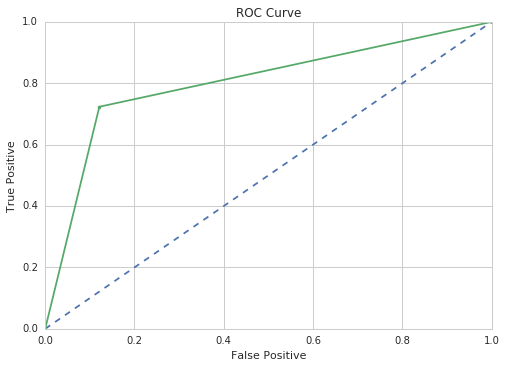

In [112]:
#plotting the ROC curve and calculating the prediction accuracy
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot
# calculate AUC
auc = roc_auc_score(y_test, gb_predictions)
print('AUC: %.2f' % auc)
print('AUC: %.3f' % auc)
auc_prob = roc_auc_score(y_test, gb_predictions_prob)
print('AUC_prob: %.2f' % auc_prob)
print('AUC_prob: %.3f' % auc_prob)
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, gb_predictions)
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
pyplot.plot(fpr, tpr, marker='.')
pyplot.xlabel('False Positive')
pyplot.ylabel('True Positive')
pyplot.title('ROC Curve')
pyplot.show()

#### Performance metrics


In [113]:
# calculate confusion matrix
y_pred = gb_predictions

def print_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    print('True positive = ', cm[0][0])
    print('False positive = ', cm[0][1])
    print('False negative = ', cm[1][0])
    print('True negative = ', cm[1][1])

print_confusion_matrix(y_test,y_pred)

True positive =  3556
False positive =  491
False negative =  1093
True negative =  2860


In [114]:
def print_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tn,fp,fn,tp = cm.ravel()
    return tn,fp,fn,tp
print_confusion_matrix(y_test,y_pred)

(3556, 491, 1093, 2860)

In [115]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.76      0.88      0.82      4047
           1       0.85      0.72      0.78      3953

    accuracy                           0.80      8000
   macro avg       0.81      0.80      0.80      8000
weighted avg       0.81      0.80      0.80      8000



#### Saving the model's learnings

In [116]:
from sklearn.externals import joblib
# Save the model as a pickle in a file
joblib.dump(gb, 'arrears_model_learnings.pkl') 

['arrears_model_learnings.pkl']

In [117]:
# Load the model from the file
gb_from_joblib = joblib.load('arrears_model_learnings.pkl') 
#gb_from_joblib.predict(x_test[:4])


#### Calculating prediction accuracy using a Light Gradient Boosting classifier


In [118]:
import lightgbm as lgb
lgbm_train = lgb.Dataset(x_train,y_train)

In [119]:
params = {}
params['learning_rate']= 0.003
params['boosting_type']='gbdt'
params['objective']='binary'
params['metric']='binary_logloss'
params['sub_feature']=0.5
params['num_leaves']= 10
params['min_data']=50
params['max_depth']=10
params['verbose'] = 1

In [120]:
clf= lgb.train(params, lgbm_train, 100)
lgbm_pred = pd.DataFrame(clf.predict(x_test))
#lgbm_pred_prob = pd.DataFrame(clf.predict_proba(x_test)[:,1])
#lgbm_pred.head()

AUC: 0.872


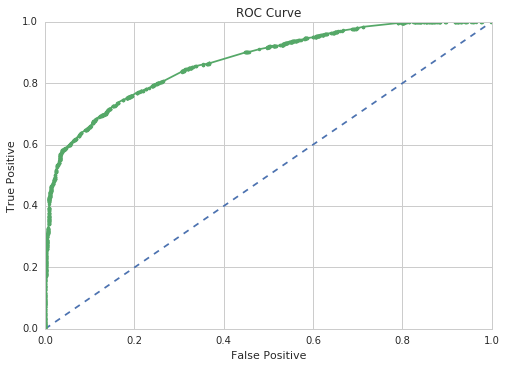

In [121]:
#plotting the ROC curve and calculating the prediction accuracy
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot
# calculate AUC
auc = roc_auc_score(y_test, lgbm_pred)
print('AUC: %.3f' % auc)
#auc_prob = roc_auc_score(y_test, lgbm_pred_prob)
#print('AUC_prob: %.3f' % auc_prob)
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, lgbm_pred)
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
pyplot.plot(fpr, tpr, marker='.')
pyplot.xlabel('False Positive')
pyplot.ylabel('True Positive')
pyplot.title('ROC Curve')
pyplot.show()

### Performance metrics

In [122]:
# calculate confusion matrix
y_pred = lgbm_pred.round()

def print_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    print('True positive = ', cm[0][0])
    print('False positive = ', cm[0][1])
    print('False negative = ', cm[1][0])
    print('True negative = ', cm[1][1])

print_confusion_matrix(y_test,y_pred)

True positive =  3481
False positive =  566
False negative =  1139
True negative =  2814


In [123]:
def print_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tn,fp,fn,tp = cm.ravel()
    return tn,fp,fn,tp
print_confusion_matrix(y_test,y_pred)

(3481, 566, 1139, 2814)

In [124]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.75      0.86      0.80      4047
           1       0.83      0.71      0.77      3953

    accuracy                           0.79      8000
   macro avg       0.79      0.79      0.79      8000
weighted avg       0.79      0.79      0.79      8000

